# **Scraping de titulares de varios periódicos**

## 1.Scrapeo de datos

In [51]:
import urllib3
from copy import deepcopy
import json
from multiprocessing.pool import ThreadPool
import re

from bs4 import BeautifulSoup

In [52]:
def get_request(uri):
    """Devuelve el request sobre una URL

    Args:
        uri (str): La url de donde obtener el Request

    Returns:
        Request: La request a la URL
    """
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [53]:
claves = {}

def get_data(map):
    """Devuelve la Lista de Datos transformados para su utilización

    Args:
        Map (Map<Key,Value>): Mapa con el periódico y los valores

    Returns:
        List: Frase Str, Url Str, Peso Float
    """
    dato=map[1]
    datos=[]
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    urls=[]
    for text in soup.find_all(dato[2],{"class":dato[3]} if len(dato[3])>0 else None):
        texto = text.text.replace("\n","")
        texto = texto.replace("\r","")
        texto = texto.replace("\t","")
        if dato[4] == ".":
            enlace = text
            bEnlace = text[dato[5]]
        else:
            enlace=text.findChildren(dato[4] , recursive=False)
            if len(enlace)==0:
                continue
            bEnlace = enlace[0][dato[5]]
        if bEnlace.startswith("/"):
            bEnlace=dato[1]+bEnlace
        datosenlace=[texto,bEnlace,0]
        datos.append(datosenlace)
        urls.append(bEnlace)
    claves[dato[0]]=urls
    return datos

In [54]:


# Recogemos los datos del fichero .json 
with open('Media/medios.json',"r") as f:
    urls = json.load(f)


DATA=[]
# Guardamos los valores transformados en una lista con su key para trastear con ellos
for key,x in urls.items():
    DATA.append([key,x['url'],x['tag'],x['clase'],x['tagURL'],x['valueURL']])

# Creamos un ThreadPool donde se ejecutará en varios procesos la búsqueda de datos, sin esto en búsqueda de 10 páginas tardaría más de 10 segundos
pool = ThreadPool(len(DATA))
datos=[]
v = pool.map(get_data, enumerate(DATA)) 
datos = [item for lista in v for item in lista]

In [55]:
# Vemos aquí los datos de cada página con toda su URL

datos

[['García Castellón prorroga seis meses la instrucción de Tsunami en la que Puigdemont está imputado por terrorismo',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/garcia-castellon-prorroga-seis-meses-instruccion-tsunami-puigdemont-imputado-terrorismo/00031706540129091974686.htm',
  0],
 ['Alcoa conecta las dos primeras cubas a la red eléctrica para su rearranque',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/29/alcoa-san-cibrao-conecta-dos-primeras-cubas-red-electrica-rearranque/00031706521378456817488.htm',
  0],
 ['Más allá de la playa y el Camino: cinco maneras diferentes de hacer turismo en Galicia',
  'http://www.lavozdegalicia.com/noticia/galicia/2024/01/29/seis-destinos-starlight-disfrutar-cielo-estrellado/0003_202401G29P3991.htm',
  0],
 ['Vox estalla en Baleares y desata una crisis institucional',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/vox-baleares-expulsa-grupo-parlamentario-presidente-parlament-presidenta-partido/0003170652715525

In [56]:
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')

stop_words = stopwords.words('spanish')

stop_words += ["\u200b", "\xa0", "para", "como", "puede","cómo", "hacer", "forma", "parte", "hace", "además", "según", "pueden", "ser","tras"]

stop_words[:10]

# Definimos los StopWords para eliminar en el contador 

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [57]:
# Añadimos a un regex todas las palabras no permitidas
regex = "|".join(stop_words)

# Hacemos deepcopy de los datos que trabajamos luego en el conteo
frasesEditadas = deepcopy(datos) 
for index,dato in enumerate(datos):
    viejaFrase=deepcopy(dato[0])
    # Filtramos las palabras
    fraseNueva = re.sub(f"\\b({regex})\\b", " ", viejaFrase)
    frasecompleta = fraseNueva.strip ()
    palabras = frasecompleta.split ()
    # Juntamos la frase completa con filtros que eliminan caracteres no deseados
    frasecompleta = " ".join([re.sub(r'^\W|\W$', '', p.lower()) for p in palabras if len(re.sub(r'^\W|\W$', '', p)) > 3])
    frasesEditadas[index] = [frasecompleta,frasesEditadas[index][1],frasesEditadas[index][2]]

In [58]:
# Vemos aquí las frases editadas

frasesEditadas

[['garcía castellón prorroga seis meses instrucción tsunami puigdemont imputado terrorismo',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/garcia-castellon-prorroga-seis-meses-instruccion-tsunami-puigdemont-imputado-terrorismo/00031706540129091974686.htm',
  0],
 ['alcoa conecta primeras cubas eléctrica rearranque',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/29/alcoa-san-cibrao-conecta-dos-primeras-cubas-red-electrica-rearranque/00031706521378456817488.htm',
  0],
 ['allá playa camino cinco maneras diferentes turismo galicia',
  'http://www.lavozdegalicia.com/noticia/galicia/2024/01/29/seis-destinos-starlight-disfrutar-cielo-estrellado/0003_202401G29P3991.htm',
  0],
 ['estalla baleares desata crisis institucional',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/vox-baleares-expulsa-grupo-parlamentario-presidente-parlament-presidenta-partido/00031706527155250396926.htm',
  0],
 ['iberdrola elige galicia instalar primera batería conectada central h

In [59]:
frecuencias = {}

# Recorro en el conteo de frecuencia de palabras
textoEntero = " ".join([sublista[0] for sublista in frasesEditadas])
for palabra in textoEntero.split():
    palabra = palabra.strip() 
    if palabra in frecuencias:
        frecuencias[palabra] += 1 # Aumenta la frecuencia si la palabra ya existe
    else:
        frecuencias[palabra] = 1 # Crea una nueva entrada si la palabra no existe

# Y calculo el valor de cada frase editada 
for index,portadaE in enumerate(frasesEditadas):
    palabras = portadaE[0].split()
    valor=0
    for palabra in palabras:
      valor+=frecuencias[palabra]
    l = len(datos[index][0].split())
    frasesEditadas[index][2]=valor/(l)
    datos[index][2]=valor/l

frecuencias

{'garcía': 7,
 'castellón': 4,
 'prorroga': 6,
 'seis': 16,
 'meses': 9,
 'instrucción': 3,
 'tsunami': 5,
 'puigdemont': 9,
 'imputado': 2,
 'terrorismo': 3,
 'alcoa': 2,
 'conecta': 1,
 'primeras': 3,
 'cubas': 2,
 'eléctrica': 4,
 'rearranque': 2,
 'allá': 1,
 'playa': 1,
 'camino': 4,
 'cinco': 24,
 'maneras': 1,
 'diferentes': 2,
 'turismo': 6,
 'galicia': 29,
 'estalla': 2,
 'baleares': 7,
 'desata': 1,
 'crisis': 13,
 'institucional': 1,
 'iberdrola': 3,
 'elige': 1,
 'instalar': 2,
 'primera': 11,
 'batería': 1,
 'conectada': 2,
 'central': 1,
 'hidroeléctrica': 1,
 'país': 5,
 'archivan': 1,
 'definitiva': 3,
 'caso': 12,
 'policías': 4,
 'gemelos': 4,
 'acusados': 2,
 'matar': 2,
 'compañero': 3,
 'comisaría': 4,
 'ourense': 7,
 'treinta': 1,
 'años': 57,
 'solo': 21,
 'aldea': 1,
 'sarria': 1,
 'veñan': 1,
 'veciños': 1,
 'honrados': 1,
 'senón': 1,
 'estou': 1,
 'mellor': 2,
 'kilómetros': 3,
 'pánico': 1,
 'ribadeo': 1,
 'mondoñedo': 1,
 'convocadas': 2,
 'plazas': 6,
 'em

In [60]:
# Saco el valor relativo de cada una de las frases

tope=max(datos,key= lambda x:x[2])[2]
for index,i in enumerate(datos):
    datos[index][2]=(i[2]/tope)
datos

[['García Castellón prorroga seis meses la instrucción de Tsunami en la que Puigdemont está imputado por terrorismo',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/garcia-castellon-prorroga-seis-meses-instruccion-tsunami-puigdemont-imputado-terrorismo/00031706540129091974686.htm',
  0.2486126526082131],
 ['Alcoa conecta las dos primeras cubas a la red eléctrica para su rearranque',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/29/alcoa-san-cibrao-conecta-dos-primeras-cubas-red-electrica-rearranque/00031706521378456817488.htm',
  0.07111756168359942],
 ['Más allá de la playa y el Camino: cinco maneras diferentes de hacer turismo en Galicia',
  'http://www.lavozdegalicia.com/noticia/galicia/2024/01/29/seis-destinos-starlight-disfrutar-cielo-estrellado/0003_202401G29P3991.htm',
  0.2806603773584906],
 ['Vox estalla en Baleares y desata una crisis institucional',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/29/vox-baleares-expulsa-grupo-parlamentario-pres

In [61]:
titularesOrdenados=sorted(datos,key= lambda x:x[2],reverse=True)

# Borramos si coincide titular
dicc = {}
for x in titularesOrdenados:
    dicc[x[0]] = x

titularesOrdenados = list(dicc.values())

# 2. **Amosar un gráfico de barras coas 10 palabras que se repiten máis**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'coruña'),
  Text(1, 0, 'años'),
  Text(2, 0, 'españa'),
  Text(3, 0, '2024'),
  Text(4, 0, 'madrid'),
  Text(5, 0, 'euros'),
  Text(6, 0, 'nuevo'),
  Text(7, 0, 'galicia'),
  Text(8, 0, 'cinco'),
  Text(9, 0, 'nueva')])

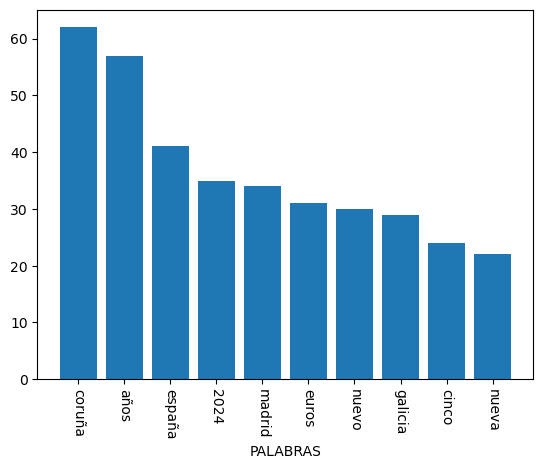

In [62]:
import matplotlib.pyplot as plt

# Ordenamos el listado y pillamos los mejores 10
diccionario_ordenado = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])

# Los ponemos en el plt.bar
plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)

# 3. **Escribir a un arquivo HTML: resultado-ano-mes-dia.html (ordeado polo peso, de modo que os titulares que aparecen máis grandes, aparezan ao inicio)**

**Librería para manejo de HTML**

In [63]:
#!conda install -y -c conda-forge airium

In [64]:
import time
from airium import Airium

a = Airium()


# Librería para el manejo de HTML
a('<!DOCTYPE html>')
with a.html(lang="pl"):
    with a.head():
        a.meta(charset="utf-8")
        a.title(_t="Página de noticias")
    with a.body():
        for portada in titularesOrdenados:
            with a.p(style=f"font-size:{portada[2]+1}em;"):
                with a.a(href=portada[1]):
                    a(portada[0])

html = str(a)  # Casteo de los datos

with open(f"HTML/resultado-{time.localtime().tm_year}-{time.localtime().tm_mon}-{time.localtime().tm_mday}.html","w+") as f:
    f.write(html)


# 4. **Amosar por pantalla os 20 titulares e a URL que teñan maior peso relativo (“relevancia”)**

In [65]:
for i in titularesOrdenados[:20]:
    print(f"URL: {i[1]} - FRASE: {i[0]}")

URL: https://www.laopinioncoruna.es/coruna/2024/01/29/cocina-corunesa-despliega-potencial-madrid-97496939.html - FRASE: A Coruña luce producto en Madrid Fusión
URL: https://www.elespanol.com/quincemil/articulos/deporte/estudiantes-reconoce-el-gran-partido-del-leyma-con-una-gran-ovacion-y-coreando-a-coruna - FRASE: Estudiantes reconoce el buen partido del Basquet Coruña con una gran ovación y coreando "A Coruña"
URL: https://www.20minutos.es/noticia/5212560/0/magerifelis-piegnei-restos-fosiles-un-felino-hace-15-millones-anos/ - FRASE: Magerifelis piegnei, el gato que habitó Madrid hace quince millones de años
URL: https://www.elespanol.com/quincemil/articulos/actualidad/doce-anos-de-la-tragedia-del-orzan-a-coruna-homenajea-a-los-tres-policias-fallecidos - FRASE: Doce años de la tragedia del Orzán: A Coruña homenajea a los tres policías fallecidos
URL: https://www.laopinioncoruna.es/coruna/2024/01/29/coruna-galicia-inician-semana-marcada-97471273.html - FRASE: A Coruña y toda Galicia ini

# 5. **Suxire un método mellor para analizar a relevancia dos titulares**

Se puede utilizar el análisis de de sentimiento, esto implica utilizar técnicas de procesamiento de lenguaje natural para determinar si el titular es positivo, natural o neutro, esto implica que los positivos y negativos seán más relevantes, mientras que los neutros los sean menos, teniendo en cuenta también la repetición de palabras y su peso en las frases, por lo que nos dar'ia una mayor precisión juntando los dos métodos

# 6. **Mete os titulares, medio, URL e peso relativo nunha BBDD de SQLite**

In [66]:
#!conda install -y sqlite3 

In [67]:
connection=None

In [68]:
import sqlite3

# Conectamos siguiendo el patrón SingleTone
if not(connection):
    connection=sqlite3.connect("Media/titulares.db")

In [69]:
# Creamos el cursor y si existe la tabla en la BBDD nos lo dice
cursor = connection.cursor()
try:
    cursor.execute("CREATE TABLE titulares (titular TEXT,medio TEXT, url TEXT, prelativo REAL)")
except:
    print("La tabla ya está creada")

La tabla ya está creada


In [70]:
def buscador_titular_peso(URL):
    """Devuelve el titular y su peso relativo

    Args:
        URL (str): URL del titular

    Returns:
        List: Devuelve el titular y peso
    """
    for i in datos:
        if i[1] == URL:
            return i[0],i[2]

In [71]:
valores = []

# Buscamos los datos a insertar y lo ejecutamos con executemany
for key,values in claves.items():
    for url in values:
        titular,peso=buscador_titular_peso(url)
        valores.append([titular,key,url,peso])


cursor.executemany("""
    INSERT INTO titulares ('titular', 'medio', 'url', 'prelativo')
    VALUES (?,?,?,?)""", valores)

#connection.commit()

In [72]:
# Vemos que se insertan o por lo menos están para commit

cursor.execute("SELECT * FROM titulares order by prelativo desc")

rows = cursor.fetchall()

rows

[('A Coruña luce producto en Madrid Fusión',
  'La opinión Coruña',
  'https://www.laopinioncoruna.es/coruna/2024/01/29/cocina-corunesa-despliega-potencial-madrid-97496939.html',
  1.0),
 ('Estudiantes reconoce el buen partido del Basquet Coruña con una gran ovación y coreando "A Coruña"',
  'El Espanol',
  'https://www.elespanol.com/quincemil/articulos/deporte/estudiantes-reconoce-el-gran-partido-del-leyma-con-una-gran-ovacion-y-coreando-a-coruna',
  0.6727594339622641),
 ('Magerifelis piegnei, el gato que habitó Madrid hace quince millones de años',
  '20 Minutos',
  'https://www.20minutos.es/noticia/5212560/0/magerifelis-piegnei-restos-fosiles-un-felino-hace-15-millones-anos/',
  0.64937106918239),
 ('Doce años de la tragedia del Orzán: A Coruña homenajea a los tres policías fallecidos',
  'El Espanol',
  'https://www.elespanol.com/quincemil/articulos/actualidad/doce-anos-de-la-tragedia-del-orzan-a-coruna-homenajea-a-los-tres-policias-fallecidos',
  0.6471698113207548),
 ('A Coruña 

In [73]:
# Y cerramos conexión

cursor.close()
connection.close()